In [9]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import glob

In [10]:
import zipfile
import os

!wget --no-check-certificate \
    "http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar" \
    -O "/tmp/imgs.rar"

--2021-11-10 08:48:17--  http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar
Resolving chaladze.com (chaladze.com)... 74.208.236.157, 2607:f1c0:100f:f000::25c
Connecting to chaladze.com (chaladze.com)|74.208.236.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138983573 (133M) [application/rar]
Saving to: ‘/tmp/imgs.rar’

/tmp/imgs.rar       100%[===================>] 132.54M  16.9MB/s    in 9.3s    

2021-11-10 08:48:27 (14.2 MB/s) - ‘/tmp/imgs.rar’ saved [138983573/138983573]



In [11]:
!pip install patool
import patoolib
!mkdir /tmp/dataset
patoolib.extract_archive("/tmp/imgs.rar", outdir="/tmp/dataset/")

patool: Extracting /tmp/imgs.rar ...
patool: running /usr/bin/unrar x -- /tmp/imgs.rar
patool:     with cwd='/tmp/dataset/'
patool: ... /tmp/imgs.rar extracted to `/tmp/dataset/'.


'/tmp/dataset/'

In [12]:
# !rm -r "/tmp/dataset/Linnaeus 5 128X128"

In [13]:
categories = ["berry", "bird", "dog", "flower", "other"]
# Location with subdirectories
for category in categories:
  my_path = "/tmp/dataset/Linnaeus 5 128X128/train/{}/".format(category)
  # Location to move images to
  main_dir = "/tmp/dataset/Linnaeus 5 128X128/train/"

  # Get List of all images
  files = glob.glob(my_path + '*.jpg', recursive=True)

  # For each image
  for file in files:
      # Get File name and extension
      filename = os.path.basename(file)
      # Copy the file with os.rename
      os.rename(
          file,
          main_dir + "{}_".format(category) + filename
      )
!rmdir "/tmp/dataset/Linnaeus 5 128X128/train/berry" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/bird" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/dog" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/flower" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/other"

In [14]:
categories = ["berry", "bird", "dog", "flower", "other"]
# Location with subdirectories
for category in categories:
  my_path = "/tmp/dataset/Linnaeus 5 128X128/test/{}/".format(category)
  # Location to move images to
  main_dir = "/tmp/dataset/Linnaeus 5 128X128/test/"

  # Get List of all images
  files = glob.glob(my_path + '*.jpg', recursive=True)

  # For each image
  for file in files:
      # Get File name and extension
      filename = os.path.basename(file)
      # Copy the file with os.rename
      os.rename(
          file,
          main_dir + "{}_".format(category) + filename
      )
!rmdir "/tmp/dataset/Linnaeus 5 128X128/test/berry" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/bird" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/dog" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/flower" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/other"

In [17]:
imdir = "/tmp/dataset/Linnaeus 5 128X128/train/"
tmdir = "/tmp/dataset/Linnaeus 5 128X128/test/"
train_files = []
test_files = []
[train_files.extend(glob.glob(imdir + '*'))]
x = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in train_files]
x_train = np.asarray(x, dtype=np.float32)
[test_files.extend(glob.glob(tmdir + '*'))]
x1 = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in test_files]
x_test = np.asarray(x1, dtype=np.float32)

In [38]:
x_train.shape, x_test.shape

((6000, 128, 128, 1), (2000, 128, 128, 1))

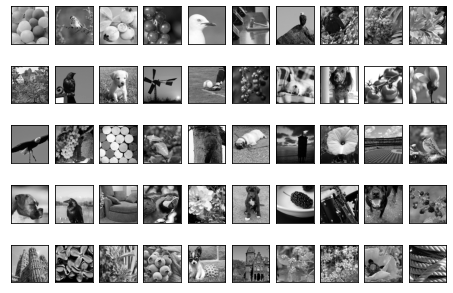

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 10) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0 
for i in range(5): 
  for j in range(10): 
    axs[i, j].imshow(x_train[a]) 
    axs[i, j].xaxis.set_visible(False) 
    axs[i, j].yaxis.set_visible(False) 
    a = a + 1



In [20]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [21]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(6000, 128, 128, 1)
(2000, 128, 128, 1)


In [22]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

In [23]:

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

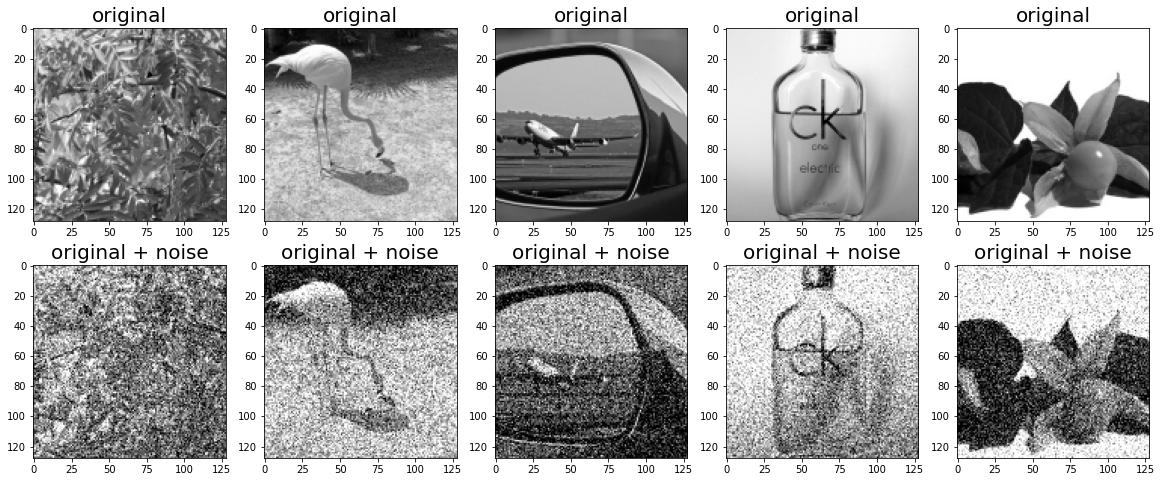

In [24]:
n = 5
plt.figure(figsize=(20, 8))
plt.gray()
for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=20) 
  plt.imshow(tf.squeeze(x_test[i])) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("original + noise", size=20) 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
plt.show()

In [25]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      Input(shape=(128, 128, 1)), 
      Conv2D(16, (3,3), activation='relu', padding='same', strides=2), 
      Conv2D(8, (3,3), activation='relu', padding='same', strides=2)]) 
    
    self.decoder = tf.keras.Sequential([ 
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

In [26]:
autoencoder = NoiseReducer()

In [27]:
autoencoder.compile(optimizer='adam', loss='mse')

In [28]:
autoencoder.fit(x_train_noisy, 
                x_train, 
                epochs=10, 
                shuffle=True, 
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
188/188 [==============================] - 37s 35ms/step - loss: 0.0211 - val_loss: 0.0069
Epoch 2/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 3/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 4/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 5/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 7/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 8/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 9/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 10/10
188/188 [==============================] - 6s 32ms/step - loss: 0.0055 - val_l

In [29]:
encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

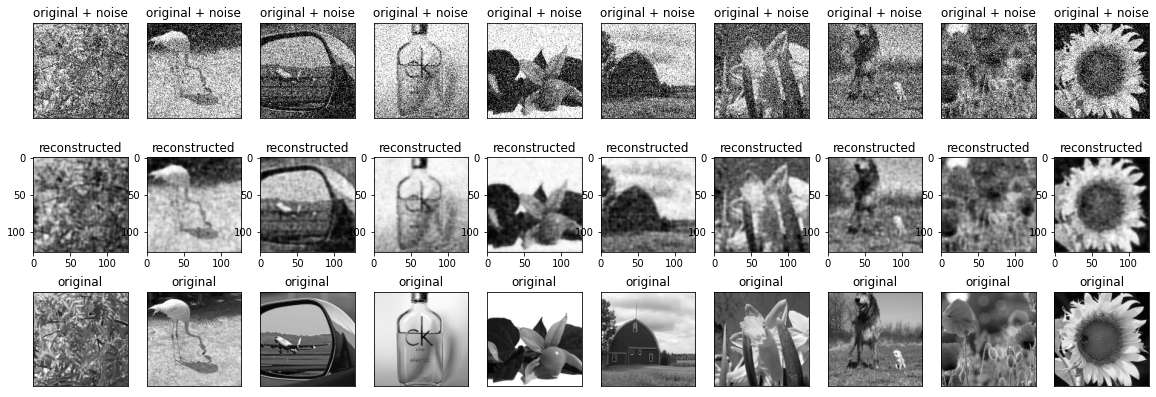

In [30]:
n = 10 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 

plt.show()

(128, 128)

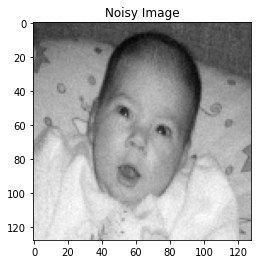

In [39]:
import cv2
test=cv2.imread("/content/kid.jpg",cv2.IMREAD_GRAYSCALE)
dim=(128,128)
test=cv2.resize(test, dim, interpolation = cv2.INTER_AREA)
test=test.astype('float32') / 255.
plt.title("Noisy Image") 
plt.imshow(test)
bx.get_xaxis().set_visible(False) 
bx.get_yaxis().set_visible(False)
test.shape

In [35]:
test=np.expand_dims(test, axis=0)
test = test[..., tf.newaxis]

test.shape

(1, 128, 128, 1)

In [36]:
e=autoencoder.encoder(test).numpy()
d=autoencoder.decoder(e)

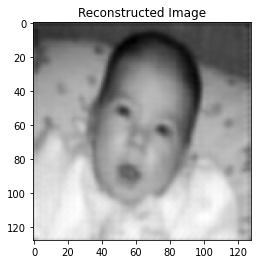

In [40]:
plt.title("Reconstructed Image") 
plt.imshow(tf.squeeze(d[0]))
bx.get_xaxis().set_visible(False) 
bx.get_yaxis().set_visible(False) 